# Librerias

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import wandb
from wandb.integration.keras import WandbCallback
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, models, transforms
# from torch.utils.data import DataLoader

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-10-24 00:48:39.832815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generación de Datos

Divisón de imágenes de 90x90 en train, validation y test

In [50]:
# Directorio de las imágenes
data_dir = 'crops_90x90'

# Directorios de salida para las imágenes
output_dir = 'crops_90x90_5clases'  # Directorio base para las nuevas carpetas
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Limpiar las carpetas principales existentes (Elimina el directorio y su contenido)
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

# Crear los directorios
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Subcarpetas adicionales para cada clase (sin "Negative")
classes = ['HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC']
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Configuración del generador de imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar todas las imágenes y etiquetas
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical',  # Multiclase inicialmente
    classes=['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC'],
    shuffle=False
)

# Obtener los nombres de archivos y etiquetas
filepaths = np.array(all_images_generator.filepaths)
labels = np.array(all_images_generator.classes)

# Índice de la clase 'Negative'
negative_index = all_images_generator.class_indices['Negative']

# Excluir las imágenes de la clase "Negative"
mask = labels != negative_index
filtered_filepaths = filepaths[mask]
filtered_labels = labels[mask]

# Dividir en entrenamiento (70%), validación (15%) y prueba (15%) para las demás clases
train_files, test_files, train_labels, test_labels = train_test_split(
    filtered_filepaths, filtered_labels, test_size=0.30, stratify=filtered_labels, random_state=42
    #stratify=filtered_labels, tomar un 70% de las imágenes de cada clase para entrenamiento en lugar de 70% aleatorio
)
val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)

# Función para copiar imágenes a las carpetas correspondientes
def copy_images(filepaths, labels, class_indices, dest_dir):
    for filepath, label in zip(filepaths, labels):
        class_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        dest_path = os.path.join(dest_dir, class_name)
        shutil.copy(filepath, dest_path)  # Copiar la imagen

# Copiar imágenes a las carpetas correspondientes en función de su clase
copy_images(train_files, train_labels, all_images_generator.class_indices, train_dir)
copy_images(val_files, val_labels, all_images_generator.class_indices, val_dir)
copy_images(test_files, test_labels, all_images_generator.class_indices, test_dir)

# Imprimir el resultado
print(f"Total de imágenes copiadas a entrenamiento: {len(train_files)}")
print(f"Total de imágenes copiadas a validación: {len(val_files)}")
print(f"Total de imágenes copiadas a prueba: {len(test_files)}")

Found 11534 images belonging to 6 classes.
Total de imágenes copiadas a entrenamiento: 3328
Total de imágenes copiadas a validación: 713
Total de imágenes copiadas a prueba: 714


#### Grafico de la distribución de las clases

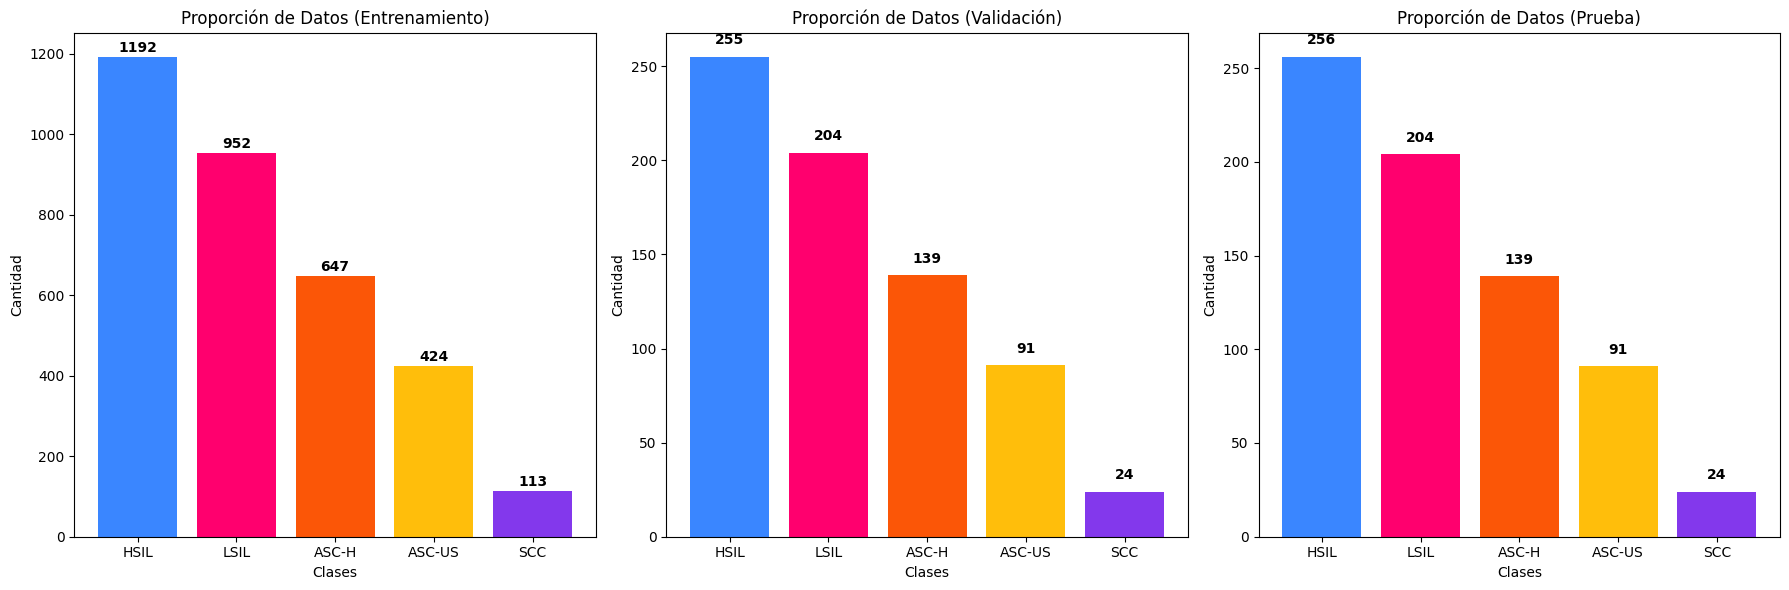

In [51]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Función para contar imágenes en cada clase dentro de una carpeta
def count_images_in_classes(folder_path, classes):
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(folder_path, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Función para crear gráficos de barras para las proporciones de las 5 clases
def plot_class_proportion_subplot(ax, class_counts, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(class_counts.keys(), class_counts.values(), color=['#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC'])
    ax.set_xlabel('Clases')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    for i, (class_name, count) in enumerate(class_counts.items()):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/val'
test_dir = 'crops_90x90_5clases/test'

# Clases a considerar
classes = ['HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC']

# Contar las imágenes en cada clase para cada conjunto
train_class_counts = count_images_in_classes(train_dir, classes)
val_class_counts = count_images_in_classes(val_dir, classes)
test_class_counts = count_images_in_classes(test_dir, classes)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_class_proportion_subplot(axes[0], train_class_counts, 'Proporción de Datos (Entrenamiento)')
plot_class_proportion_subplot(axes[1], val_class_counts, 'Proporción de Datos (Validación)')
plot_class_proportion_subplot(axes[2], test_class_counts, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()


#### Aumentación de Imagenes de las clases minoritarias

In [52]:
from PIL import Image

# Directorios de las clases minoritarias (SCC y ASC-US)
minority_classes = ['SCC', 'ASC-US']
train_dir = 'crops_90x90_5clases/train'

# Parámetros de aumentación
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotaciones leves para preservar la estructura del núcleo
    horizontal_flip=True,   # Flip horizontal --> Ayuda a que el modelo generalice mejor, introduciendo diferentes perspectivas
    vertical_flip=True,     # Flip vertical
    brightness_range=[0.8, 1.2],    # Cambios en el brillo para simular variaciones de iluminación
    fill_mode='nearest'         # Relleno de los bordes con los valores de los píxeles más cercanos tras los cambios de transformación 
)

# Función para realizar aumentación de imágenes y guardarlas
def augment_images(class_dir, target_count):
    # Obtener las imágenes actuales de la clase
    images = os.listdir(class_dir)
    current_count = len(images)
    
    # Si ya hay suficientes imágenes, no hacer nada
    if current_count >= target_count:
        return
    
    print(f"Realizando aumentación para la clase {os.path.basename(class_dir)}...")
    
    while current_count < target_count:
        for img_name in images:
            # Cargar la imagen
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            img_array = np.array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Expandir dimensiones
            
            # Generar nuevas imágenes aumentadas
            aug_iter = datagen.flow(img_array, batch_size=1, save_to_dir=class_dir, 
                                    save_prefix='aug', save_format='png')
            
            # Guardar las nuevas imágenes hasta alcanzar el objetivo
            for _ in range(1):  # Puedes generar más de una imagen por iteración si es necesario
                next(aug_iter)
                current_count += 1
                if current_count >= target_count:
                    break
                
            if current_count >= target_count:
                break  

# Cantidad objetivo de imágenes para igualar las clases más grandes 
target_image_count = 600

# Realizar aumentación en las clases minoritarias
for minority_class in minority_classes:
    class_dir = os.path.join(train_dir, minority_class)
    augment_images(class_dir, target_image_count)

print("Aumentación completada.")

Realizando aumentación para la clase SCC...
Realizando aumentación para la clase ASC-US...
Aumentación completada.


#### Grafico con la distribución de las clases luego de la aumentación

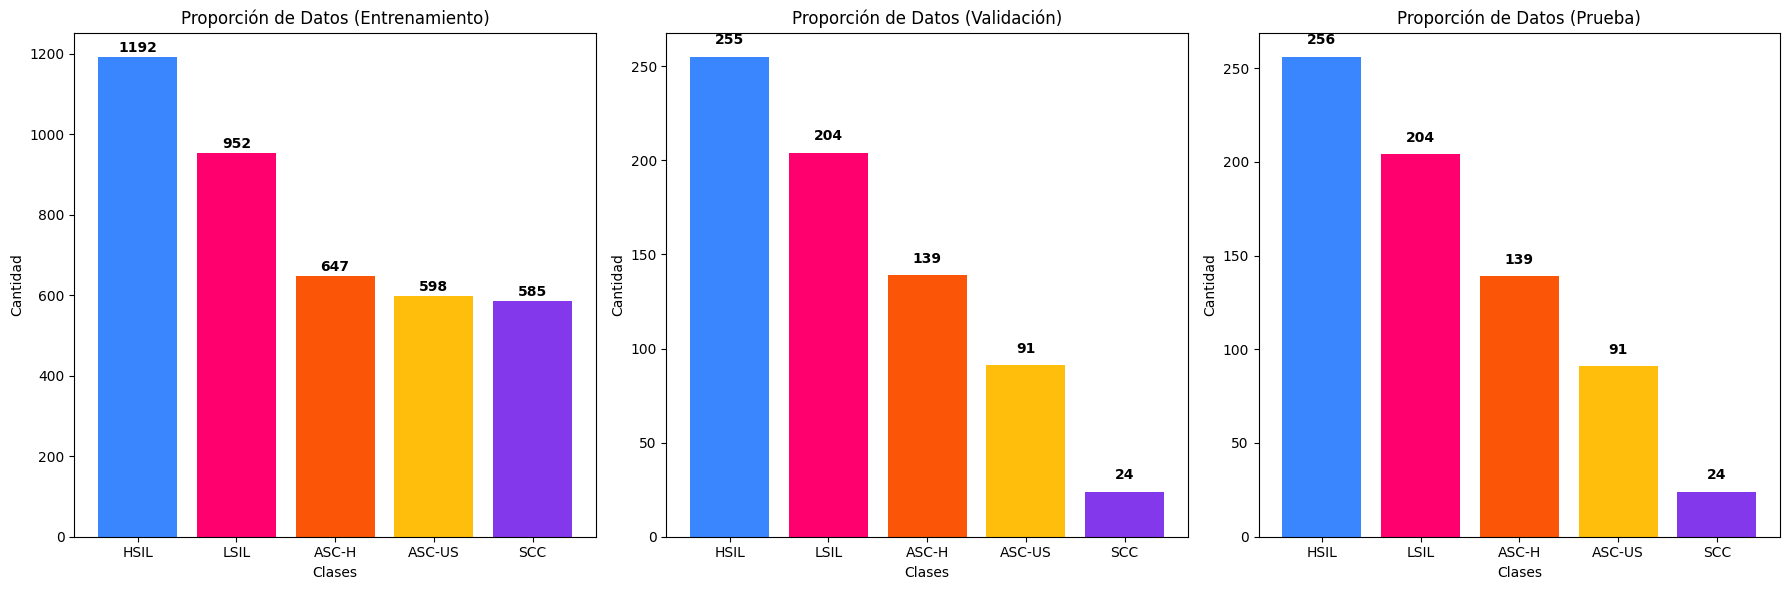

In [53]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Función para contar imágenes en cada clase dentro de una carpeta
def count_images_in_classes(folder_path, classes):
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(folder_path, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Función para crear gráficos de barras para las proporciones de las 5 clases
def plot_class_proportion_subplot(ax, class_counts, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(class_counts.keys(), class_counts.values(), color=['#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC'])
    ax.set_xlabel('Clases')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    for i, (class_name, count) in enumerate(class_counts.items()):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/val'
test_dir = 'crops_90x90_5clases/test'

# Clases a considerar
classes = ['HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC']

# Contar las imágenes en cada clase para cada conjunto
train_class_counts = count_images_in_classes(train_dir, classes)
val_class_counts = count_images_in_classes(val_dir, classes)
test_class_counts = count_images_in_classes(test_dir, classes)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_class_proportion_subplot(axes[0], train_class_counts, 'Proporción de Datos (Entrenamiento)')
plot_class_proportion_subplot(axes[1], val_class_counts, 'Proporción de Datos (Validación)')
plot_class_proportion_subplot(axes[2], test_class_counts, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

# Modelo EfficientNetB0

#### Generación de los datos de entrenamiento, validación y test

In [54]:
# Configuración de directorios y generadores de datos
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/validation'
test_dir = 'crops_90x90_5clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

Found 3974 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 714 images belonging to 5 classes.


In [56]:
import random

# # Inicializar Weights & Biases 
# wandb.login()
# wandb.init(project='clasificacion-celulas-5clases', entity='tp3-td6', name='EfficientNetB0')


# Configurar y compilar un modelo basado en EfficientNetB0

# Cargar EfficientNetB0 con pesos preentrenados
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])

# Entrenar el modelo 

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
# model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# wandb_callback = WandbCallback(save_model=False)

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]  # Añadir EarlyStopping y ReduceLROnPlateau
)

# Loggear los resultados en WandB
# wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
# wandb.finish()



Epoch 1/30


2024-10-24 18:33:37.268196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - ETA: 0s - loss: 1.3575 - accuracy: 0.4109 - precision: 0.5944 - recall: 0.1663 - auc: 0.7419 - f1_score: 0.7419

2024-10-24 18:35:53.666550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - 149s 1s/step - loss: 1.3575 - accuracy: 0.4109 - precision: 0.5944 - recall: 0.1663 - auc: 0.7419 - f1_score: 0.7419 - val_loss: 1.2401 - val_accuracy: 0.4755 - val_precision: 0.7099 - val_recall: 0.1613 - val_auc: 0.8001 - val_f1_score: 0.8001 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 140s 1s/step - loss: 1.2557 - accuracy: 0.4590 - precision: 0.6116 - recall: 0.2365 - auc: 0.7873 - f1_score: 0.7873 - val_loss: 1.1625 - val_accuracy: 0.5217 - val_precision: 0.6877 - val_recall: 0.2749 - val_auc: 0.8221 - val_f1_score: 0.8221 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 141s 1s/step - loss: 1.2001 - accuracy: 0.4834 - precision: 0.6156 - recall: 0.2713 - auc: 0.8073 - f1_score: 0.8073 - val_loss: 1.1907 - val_accuracy: 0.4853 - val_precision: 0.6097 - val_recall: 0.2651 - val_auc: 0.8127 - val_f1_score: 0.8127 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 138s 1s/s

#### Evaluación

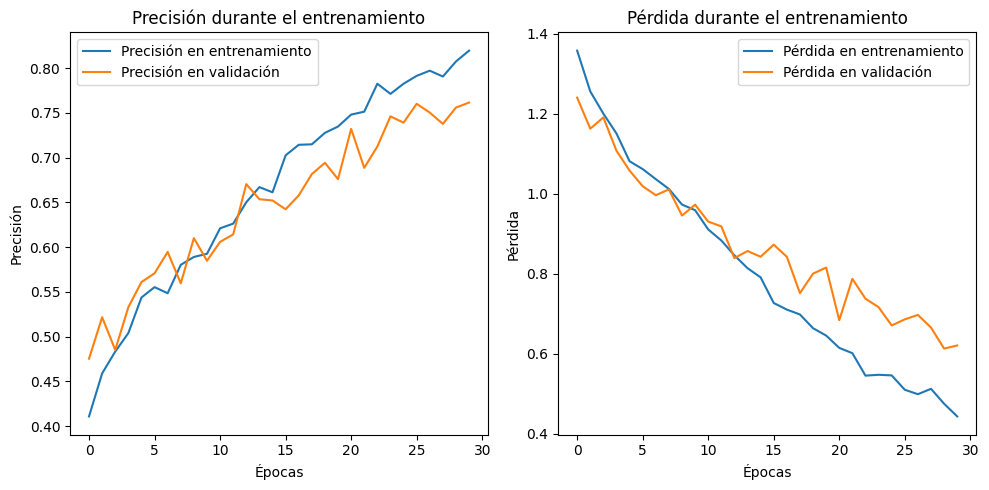

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Gráfica de precisión durante el entrenamiento
plt.subplot(1, 2, 1)        # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

2024-10-24 19:43:24.363280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 11s 476ms/step - loss: 2.8312 - accuracy: 0.3165 - precision: 0.3310 - recall: 0.2689 - auc: 0.6406 - f1_score: 0.6406
Pérdida en el conjunto de prueba: 2.8312158584594727
accuracy en el conjunto de prueba: 0.3165266215801239
Precision en el conjunto de prueba: 0.33103448152542114
Recall en el conjunto de prueba: 0.2689075767993927
AUC en el conjunto de prueba: 0.6406114101409912
F1-Score en el conjunto de prueba: 0.6406114101409912


**Matriz de confusión**

2024-10-24 19:43:45.255068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 12s 482ms/step


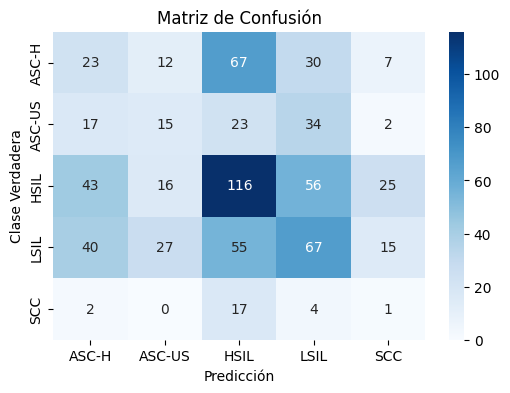

In [59]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Modelo EfficientNetB4

In [32]:
# Configuración de directorios y generadores de datos
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/validation'
test_dir = 'crops_90x90_5clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

Found 3975 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 714 images belonging to 5 classes.


In [33]:
# # Inicializar Weights & Biases 
# wandb.login()
# wandb.init(project='clasificacion-celulas-5clases', entity='tp3-td6', name='EfficientNetB4-balanceado')

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])

# Entrenar el modelo 

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
# model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# wandb_callback = WandbCallback(save_model=False)

# Entrenar el modelo con callbacks
history_B4 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]  # Añadir EarlyStopping y ReduceLROnPlateau
)

# # Evaluar el modelo en el conjunto de prueba
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# # Loggear los resultados en WandB
# wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
# wandb.finish()

Epoch 1/30


2024-10-24 03:29:35.043165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - ETA: 0s - loss: 1.2214 - accuracy: 0.4760 - precision: 0.6223 - recall: 0.2496 - auc: 0.8018 - f1_score: 0.8018

2024-10-24 03:38:34.560732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - 572s 4s/step - loss: 1.2214 - accuracy: 0.4760 - precision: 0.6223 - recall: 0.2496 - auc: 0.8018 - f1_score: 0.8018 - val_loss: 1.0708 - val_accuracy: 0.5484 - val_precision: 0.6538 - val_recall: 0.3338 - val_auc: 0.8506 - val_f1_score: 0.8506 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 558s 4s/step - loss: 0.9561 - accuracy: 0.6020 - precision: 0.7107 - recall: 0.4574 - auc: 0.8829 - f1_score: 0.8829 - val_loss: 0.8899 - val_accuracy: 0.6381 - val_precision: 0.7243 - val_recall: 0.4937 - val_auc: 0.9011 - val_f1_score: 0.9011 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 548s 4s/step - loss: 0.7766 - accuracy: 0.6792 - precision: 0.7598 - recall: 0.5746 - auc: 0.9230 - f1_score: 0.9230 - val_loss: 0.7266 - val_accuracy: 0.7083 - val_precision: 0.7868 - val_recall: 0.5694 - val_auc: 0.9353 - val_f1_score: 0.9353 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 549s 4s/s

#### Evaluación

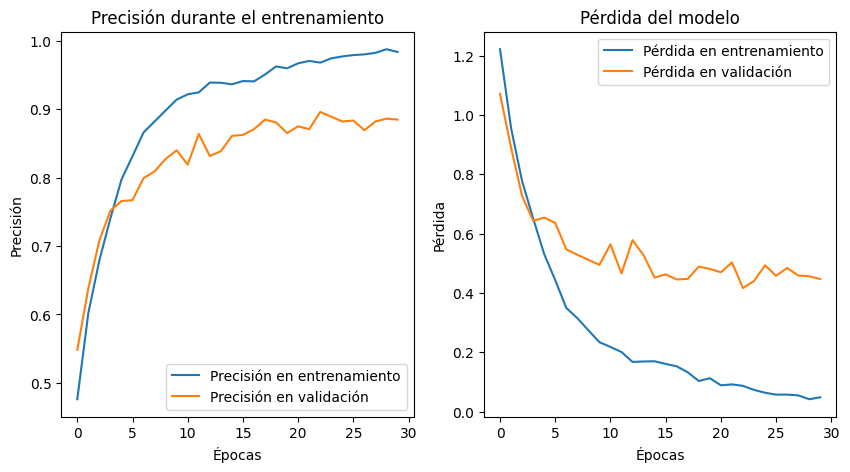

In [34]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(10, 5))  #

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history_B4.history['accuracy'], label='Precisión en entrenamiento')  
plt.plot(history_B4.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history_B4.history['loss'], label='Pérdida en entrenamiento')  
plt.plot(history_B4.history['val_loss'], label='Pérdida en validación')  
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

In [35]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

2024-10-24 08:00:21.204982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 30s 1s/step - loss: 4.0842 - accuracy: 0.3347 - precision: 0.3378 - recall: 0.3193 - auc: 0.6267 - f1_score: 0.6267
Pérdida en el conjunto de prueba: 4.084158897399902
accuracy en el conjunto de prueba: 0.33473390340805054
Precision en el conjunto de prueba: 0.3377777636051178
Recall en el conjunto de prueba: 0.3193277418613434
AUC en el conjunto de prueba: 0.626747190952301
F1-Score en el conjunto de prueba: 0.626747190952301


**Matriz de confusión**

2024-10-24 08:00:50.823941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 33s 1s/step


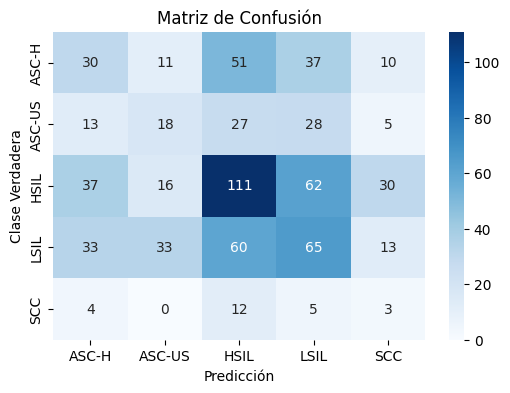

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Modelo EfficientNetB5

In [60]:
# Configuración de directorios y generadores de datos
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/validation'
test_dir = 'crops_90x90_5clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

Found 3974 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 714 images belonging to 5 classes.


In [61]:
# # Inicializar WandB
# wandb.login()
# wandb.init(project='clasificacion-celulas', name='EfficientNetB5')

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])

# Entrenar el modelo 

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
# model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# wandb_callback = WandbCallback(save_model=False)

# Entrenar el modelo con callbacks
history_B5 = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]  # Añadir EarlyStopping y ReduceLROnPlateau
)

# # Evaluar el modelo en el conjunto de prueba
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
# wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
# wandb.finish()

Epoch 1/12


2024-10-24 19:46:58.694903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - ETA: 0s - loss: 1.2473 - accuracy: 0.4623 - precision: 0.6630 - recall: 0.2247 - auc: 0.7904 - f1_score: 0.7904

2024-10-24 20:01:27.133864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - 916s 7s/step - loss: 1.2473 - accuracy: 0.4623 - precision: 0.6630 - recall: 0.2247 - auc: 0.7904 - f1_score: 0.7904 - val_loss: 1.0614 - val_accuracy: 0.5498 - val_precision: 0.6734 - val_recall: 0.3296 - val_auc: 0.8554 - val_f1_score: 0.8554 - lr: 1.0000e-04
Epoch 2/12
125/125 [==============================] - 844s 7s/step - loss: 0.9124 - accuracy: 0.6195 - precision: 0.7333 - recall: 0.4844 - auc: 0.8940 - f1_score: 0.8940 - val_loss: 0.8447 - val_accuracy: 0.6592 - val_precision: 0.7613 - val_recall: 0.5414 - val_auc: 0.9099 - val_f1_score: 0.9099 - lr: 1.0000e-04
Epoch 3/12
125/125 [==============================] - 840s 7s/step - loss: 0.7243 - accuracy: 0.7096 - precision: 0.7935 - recall: 0.6100 - auc: 0.9337 - f1_score: 0.9337 - val_loss: 0.7598 - val_accuracy: 0.7111 - val_precision: 0.7740 - val_recall: 0.6101 - val_auc: 0.9260 - val_f1_score: 0.9260 - lr: 1.0000e-04
Epoch 4/12
125/125 [==============================] - 839s 7s/s

#### Evaluación

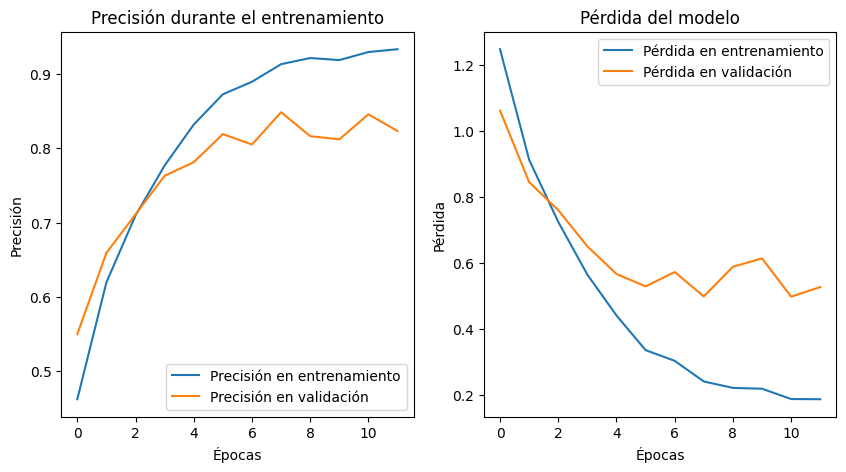

In [62]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(10, 5))  #

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history_B5.history['accuracy'], label='Precisión en entrenamiento')  
plt.plot(history_B5.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history_B5.history['loss'], label='Pérdida en entrenamiento')  
plt.plot(history_B5.history['val_loss'], label='Pérdida en validación')  
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

In [63]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

2024-10-24 23:08:45.779553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 44s 2s/step - loss: 3.4933 - accuracy: 0.2997 - precision: 0.3041 - recall: 0.2717 - auc: 0.6059 - f1_score: 0.6059
Pérdida en el conjunto de prueba: 3.493309497833252
accuracy en el conjunto de prueba: 0.299719899892807
Precision en el conjunto de prueba: 0.3040752410888672
Recall en el conjunto de prueba: 0.2717086970806122
AUC en el conjunto de prueba: 0.6058540940284729
F1-Score en el conjunto de prueba: 0.6058540940284729


**Matriz de confusión**

2024-10-24 23:09:35.389259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 48s 2s/step


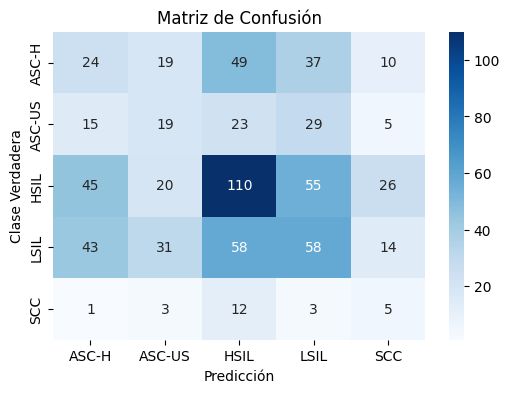

In [64]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Modelo MobileNetV2

In [109]:
# Configuración de directorios y generadores de datos
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/validation'
test_dir = 'crops_90x90_5clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT, IMG_WIDTH = 90, 90
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

Found 3974 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 714 images belonging to 5 classes.


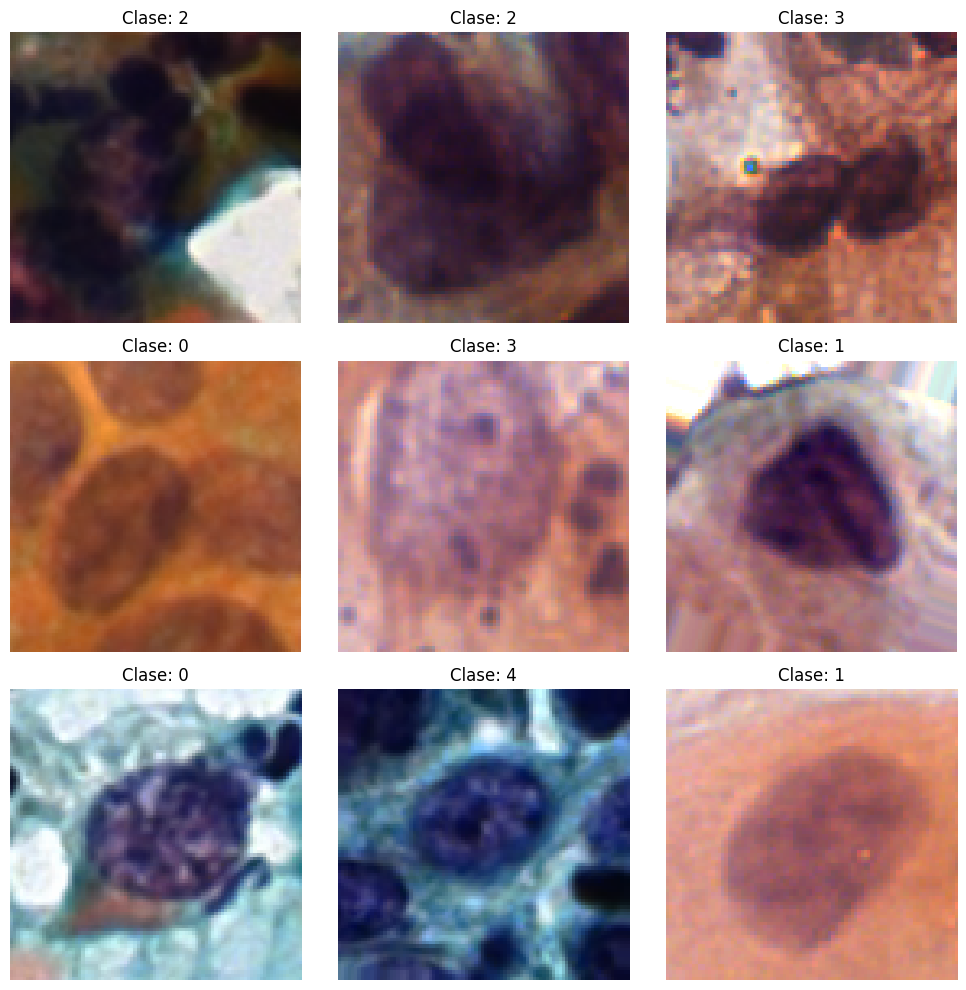

In [110]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes y etiquetas del generador de entrenamiento
images, labels = train_generator.next()

# Definir el número de imágenes a mostrar
num_images = 9
plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Clase: {labels[i].argmax()}')  # Muestra la clase con mayor probabilidad
    plt.axis('off')

plt.tight_layout()
plt.show()



In [111]:
# # Inicializar WandB
# wandb.login()
# wandb.init(project='clasificacion-celulas', name='MobileNetV2')

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])

# Entrenar el modelo 

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
# model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# wandb_callback = WandbCallback(save_model=False)

# Entrenar el modelo con callbacks
history_MN_V2 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]  # Añadir EarlyStopping y ReduceLROnPlateau
)

# # Evaluar el modelo en el conjunto de prueba
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# # Loggear los resultados en WandB
# wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
# wandb.finish()

Epoch 1/30


2024-10-25 16:42:14.402095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - ETA: 0s - loss: 1.6570 - accuracy: 0.3868 - precision: 0.4376 - recall: 0.2733 - auc: 0.7013 - f1_score: 0.7013

2024-10-25 16:42:28.163272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - 16s 90ms/step - loss: 1.6570 - accuracy: 0.3868 - precision: 0.4376 - recall: 0.2733 - auc: 0.7013 - f1_score: 0.7013 - val_loss: 1.0179 - val_accuracy: 0.5806 - val_precision: 0.6823 - val_recall: 0.4278 - val_auc: 0.8666 - val_f1_score: 0.8666 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 11s 86ms/step - loss: 1.0161 - accuracy: 0.5964 - precision: 0.6666 - recall: 0.4829 - auc: 0.8697 - f1_score: 0.8697 - val_loss: 0.8410 - val_accuracy: 0.6662 - val_precision: 0.7481 - val_recall: 0.5414 - val_auc: 0.9109 - val_f1_score: 0.9109 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 10s 81ms/step - loss: 0.7949 - accuracy: 0.6852 - precision: 0.7586 - recall: 0.5979 - auc: 0.9193 - f1_score: 0.9193 - val_loss: 0.7273 - val_accuracy: 0.7167 - val_precision: 0.7810 - val_recall: 0.6353 - val_auc: 0.9328 - val_f1_score: 0.9328 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 10s 81

#### Evaluación

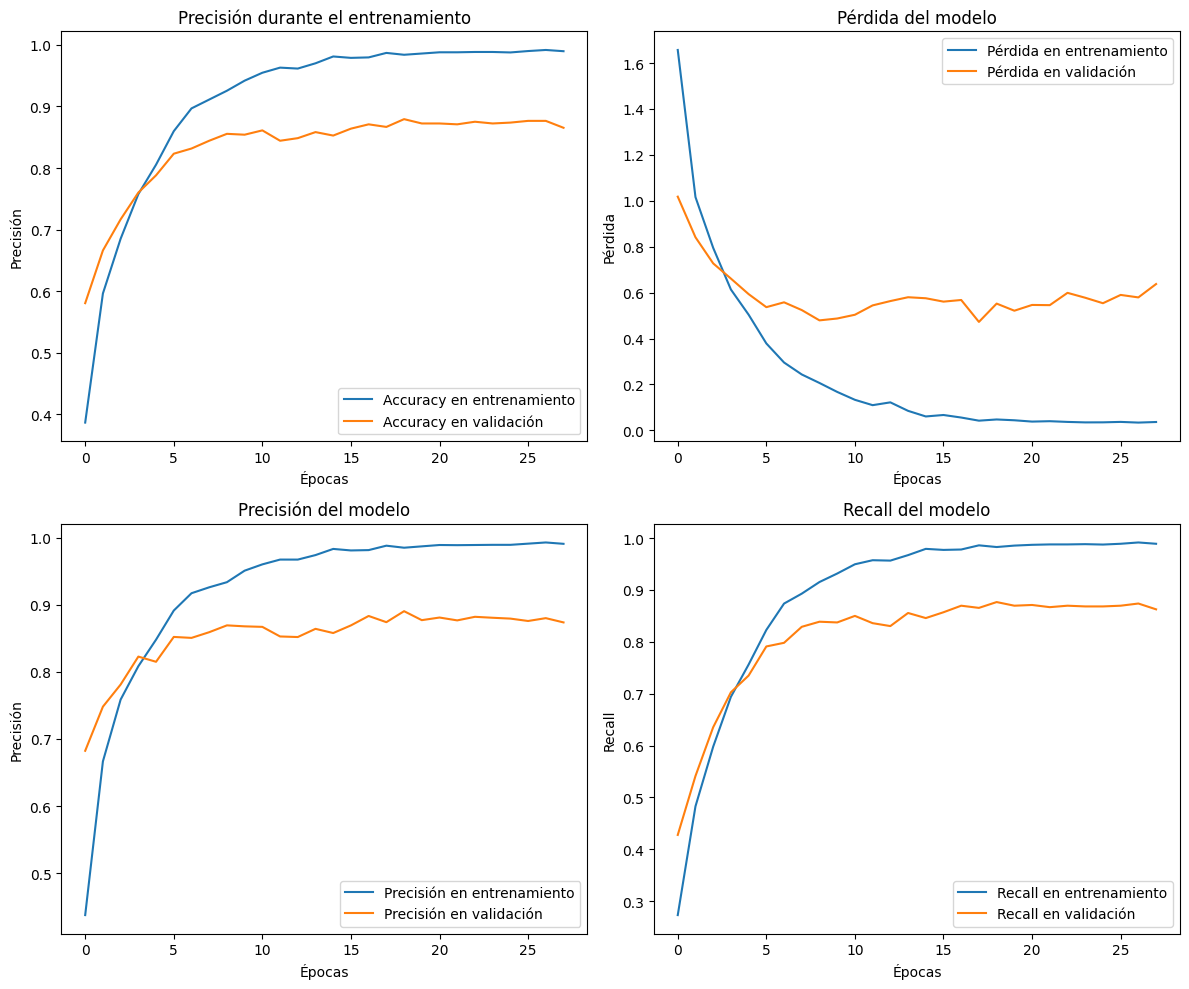

In [115]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_MN_V2.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_MN_V2.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_MN_V2.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_MN_V2.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_MN_V2.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_MN_V2.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_MN_V2.history['recall'], label='Recall en entrenamiento')
plt.plot(history_MN_V2.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()


In [116]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

 3/23 [==>...........................] - ETA: 0s - loss: 4.9015 - accuracy: 0.1667 - precision: 0.1613 - recall: 0.1562 - auc: 0.5168 - f1_score: 0.5168

2024-10-25 16:51:10.550983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 49ms/step - loss: 4.0811 - accuracy: 0.2787 - precision: 0.2734 - recall: 0.2577 - auc: 0.5983 - f1_score: 0.5983
Pérdida en el conjunto de prueba: 4.081068515777588
accuracy en el conjunto de prueba: 0.2787114977836609
Precision en el conjunto de prueba: 0.2734026610851288
Recall en el conjunto de prueba: 0.25770309567451477
AUC en el conjunto de prueba: 0.5982586741447449
F1-Score en el conjunto de prueba: 0.5982586741447449


**Matriz de confusión**

2024-10-25 16:51:17.749005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 2s 50ms/step


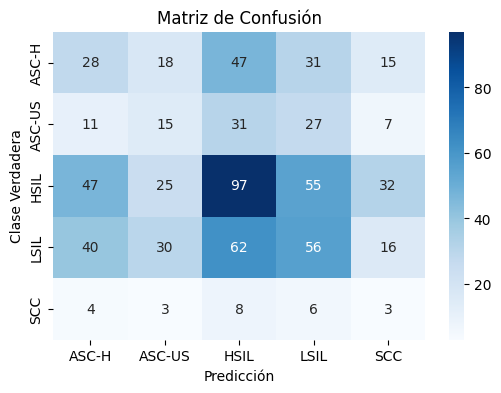

In [117]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

 3/23 [==>...........................] - ETA: 0s

2024-10-25 16:54:34.369822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 51ms/step


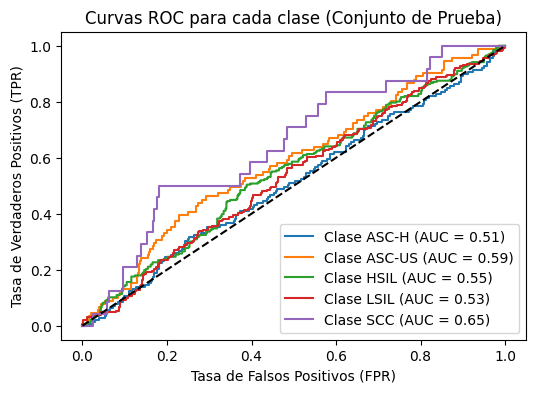

AUC Promedio: 0.56


In [120]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Obtener las etiquetas verdaderas y las predicciones
test_generator.reset()  # Asegúrate de que el generador esté en el inicio
predictions = model.predict(test_generator)  # Genera las predicciones del modelo
true_classes = test_generator.classes  # Etiquetas verdaderas
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases

# Binarizar las etiquetas verdaderas
n_classes = len(class_labels)
true_binarized = label_binarize(true_classes, classes=np.arange(n_classes))

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(6, 4))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para cada clase (Conjunto de Prueba)')
plt.legend(loc="best")
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')


# Modelo MobileNetV3

In [70]:
# Configuración de directorios y generadores de datos
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/validation'
test_dir = 'crops_90x90_5clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

Found 3974 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 714 images belonging to 5 classes.


In [81]:
from tensorflow.keras.applications import MobileNetV3Large

# # Inicializar WandB
# wandb.login()
# wandb.init(project='clasificacion-celulas', name='MobileNetV3')

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
# model_checkpoint = ModelCheckpoint('best_model_mobilenet.keras', monitor='val_loss', save_best_only=True, verbose=1)
# wandb_callback = WandbCallback(save_model=False)

# Entrenar el modelo con callbacks
history_MN_V3 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
)

# # Evaluar el modelo en el conjunto de prueba
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# # Loggear los resultados en WandB
# wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
# wandb.finish()

Epoch 1/30


2024-10-25 00:26:55.901888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - ETA: 0s - loss: 1.3348 - accuracy: 0.4137 - precision: 0.5376 - recall: 0.1746 - auc: 0.7560 - f1_score: 0.7560

2024-10-25 00:28:14.896834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - 85s 616ms/step - loss: 1.3348 - accuracy: 0.4137 - precision: 0.5376 - recall: 0.1746 - auc: 0.7560 - f1_score: 0.7560 - val_loss: 1.2087 - val_accuracy: 0.4895 - val_precision: 0.6726 - val_recall: 0.2104 - val_auc: 0.8070 - val_f1_score: 0.8070 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 75s 604ms/step - loss: 1.1303 - accuracy: 0.5239 - precision: 0.6384 - recall: 0.3244 - auc: 0.8326 - f1_score: 0.8326 - val_loss: 1.0559 - val_accuracy: 0.5568 - val_precision: 0.6714 - val_recall: 0.3324 - val_auc: 0.8572 - val_f1_score: 0.8572 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 72s 576ms/step - loss: 1.0314 - accuracy: 0.5687 - precision: 0.6594 - recall: 0.3971 - auc: 0.8619 - f1_score: 0.8619 - val_loss: 0.9464 - val_accuracy: 0.6213 - val_precision: 0.7130 - val_recall: 0.4600 - val_auc: 0.8855 - val_f1_score: 0.8855 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 71s

#### Evaluación

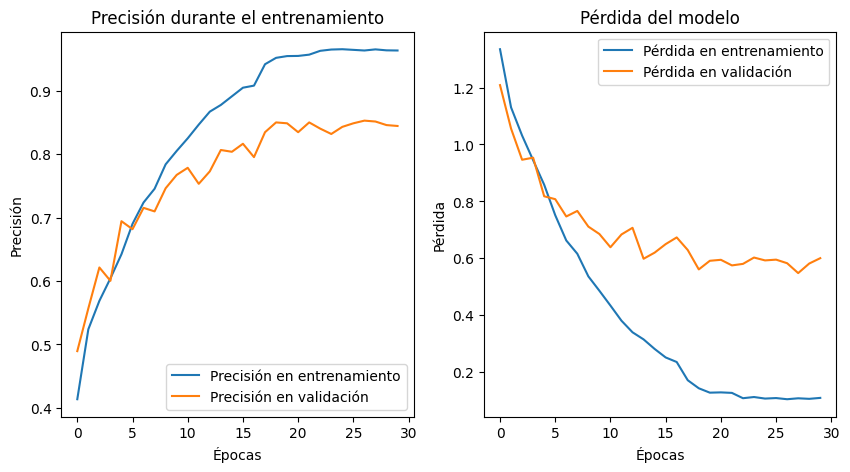

In [82]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(10, 5))  

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history_MN_V3.history['accuracy'], label='Precisión en entrenamiento')  
plt.plot(history_MN_V3.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history_MN_V3.history['loss'], label='Pérdida en entrenamiento')  
plt.plot(history_MN_V3.history['val_loss'], label='Pérdida en validación')  
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

In [83]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

2024-10-25 01:02:41.769744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 5s 194ms/step - loss: 3.4826 - accuracy: 0.3095 - precision: 0.3237 - recall: 0.2983 - auc: 0.6230 - f1_score: 0.6230
Pérdida en el conjunto de prueba: 3.4826393127441406
accuracy en el conjunto de prueba: 0.3095238208770752
Precision en el conjunto de prueba: 0.3237082064151764
Recall en el conjunto de prueba: 0.29831933975219727
AUC en el conjunto de prueba: 0.622951090335846
F1-Score en el conjunto de prueba: 0.622951090335846


**Matriz de confusión**

2024-10-25 01:02:50.017131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 5s 188ms/step


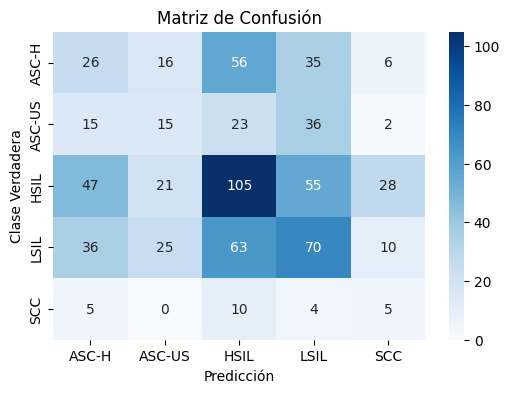

In [84]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Modelo InceptionV3

In [85]:
# Configuración de directorios y generadores de datos
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/validation'
test_dir = 'crops_90x90_5clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

Found 3974 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 714 images belonging to 5 classes.


In [87]:
# # Inicializar WandB
# wandb.login()
# wandb.init(project='clasificacion-celulas', name='InceptionV3')

# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
# model_checkpoint = ModelCheckpoint('best_model_mobilenet.keras', monitor='val_loss', save_best_only=True, verbose=1)
# wandb_callback = WandbCallback(save_model=False)

# Entrenar el modelo con callbacks
history_I_V3 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
)

# # Evaluar el modelo en el conjunto de prueba
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# # Loggear los resultados en WandB
# wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
# wandb.finish()


Epoch 1/10


2024-10-25 01:56:27.460545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.5264 - precision: 0.6847 - recall: 0.3447 - auc: 0.8355 - f1_score: 0.8355

2024-10-25 02:00:37.539564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - 272s 2s/step - loss: 1.1213 - accuracy: 0.5264 - precision: 0.6847 - recall: 0.3447 - auc: 0.8355 - f1_score: 0.8355 - val_loss: 0.6398 - val_accuracy: 0.7532 - val_precision: 0.8322 - val_recall: 0.6606 - val_auc: 0.9525 - val_f1_score: 0.9525 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 263s 2s/step - loss: 0.4973 - accuracy: 0.8098 - precision: 0.8470 - recall: 0.7620 - auc: 0.9682 - f1_score: 0.9682 - val_loss: 0.4148 - val_accuracy: 0.8696 - val_precision: 0.8811 - val_recall: 0.8317 - val_auc: 0.9774 - val_f1_score: 0.9774 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 262s 2s/step - loss: 0.2047 - accuracy: 0.9290 - precision: 0.9400 - recall: 0.9182 - auc: 0.9943 - f1_score: 0.9943 - val_loss: 0.3774 - val_accuracy: 0.8934 - val_precision: 0.9024 - val_recall: 0.8822 - val_auc: 0.9773 - val_f1_score: 0.9773 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 261s 2s/s

#### Evaluación

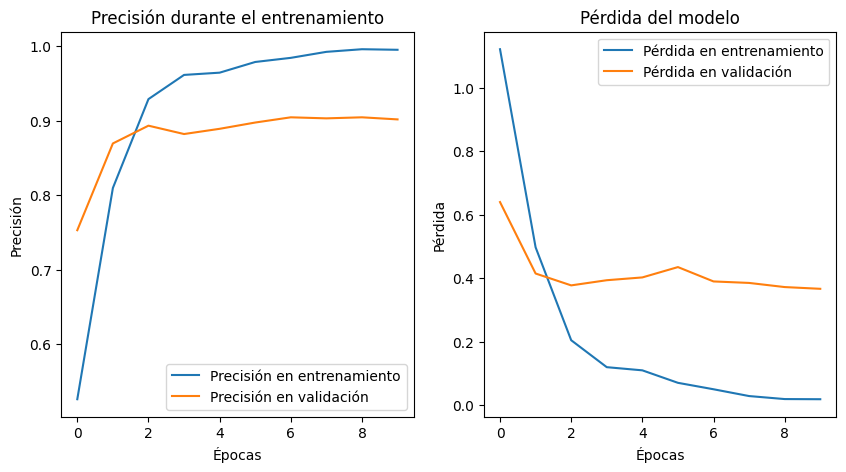

In [88]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(10, 5))  #

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history_I_V3.history['accuracy'], label='Precisión en entrenamiento')  
plt.plot(history_I_V3.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history_I_V3.history['loss'], label='Pérdida en entrenamiento')  
plt.plot(history_I_V3.history['val_loss'], label='Pérdida en validación')  
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

In [89]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

2024-10-25 02:41:28.065448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 22s 939ms/step - loss: 4.2984 - accuracy: 0.2997 - precision: 0.3090 - recall: 0.2843 - auc: 0.5986 - f1_score: 0.5986
Pérdida en el conjunto de prueba: 4.298374176025391
accuracy en el conjunto de prueba: 0.299719899892807
Precision en el conjunto de prueba: 0.30898022651672363
Recall en el conjunto de prueba: 0.28431373834609985
AUC en el conjunto de prueba: 0.5985993146896362
F1-Score en el conjunto de prueba: 0.5985993146896362


**Matriz de confusión**

2024-10-25 02:41:53.244057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 25s 1s/step


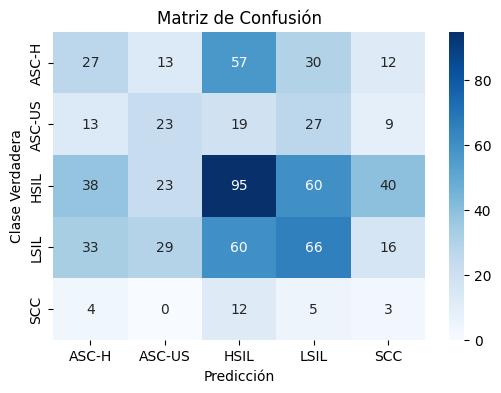

In [90]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Modelo Xception

In [91]:
# Configuración de directorios y generadores de datos
train_dir = 'crops_90x90_5clases/train'
val_dir = 'crops_90x90_5clases/validation'
test_dir = 'crops_90x90_5clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

Found 3974 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 714 images belonging to 5 classes.


In [92]:
# # Inicializar WandB
# wandb.login()
# wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='Xception-balanceado')

# Importar y Definir el Modelo Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
# model_checkpoint = ModelCheckpoint('best_model_mobilenet.keras', monitor='val_loss', save_best_only=True, verbose=1)
# wandb_callback = WandbCallback(save_model=False)

# Entrenar el modelo con callbacks
history_X = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
)

# # Evaluar el modelo en el conjunto de prueba
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# # Loggear los resultados en WandB
# wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
# wandb.finish()

83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/10


2024-10-25 02:42:46.692586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.5571 - precision: 0.7260 - recall: 0.3100 - auc: 0.8471 - f1_score: 0.8471

2024-10-25 02:49:19.200204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


125/125 [==============================] - 433s 3s/step - loss: 1.1023 - accuracy: 0.5571 - precision: 0.7260 - recall: 0.3100 - auc: 0.8471 - f1_score: 0.8471 - val_loss: 0.8009 - val_accuracy: 0.6718 - val_precision: 0.7576 - val_recall: 0.5259 - val_auc: 0.9211 - val_f1_score: 0.9211 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 430s 3s/step - loss: 0.6179 - accuracy: 0.7529 - precision: 0.8243 - recall: 0.6764 - auc: 0.9529 - f1_score: 0.9529 - val_loss: 0.4988 - val_accuracy: 0.8219 - val_precision: 0.8658 - val_recall: 0.7602 - val_auc: 0.9712 - val_f1_score: 0.9712 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 429s 3s/step - loss: 0.3320 - accuracy: 0.8888 - precision: 0.9184 - recall: 0.8468 - auc: 0.9875 - f1_score: 0.9875 - val_loss: 0.3494 - val_accuracy: 0.8906 - val_precision: 0.9130 - val_recall: 0.8682 - val_auc: 0.9822 - val_f1_score: 0.9822 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 429s 3s/s

#### Evaluación

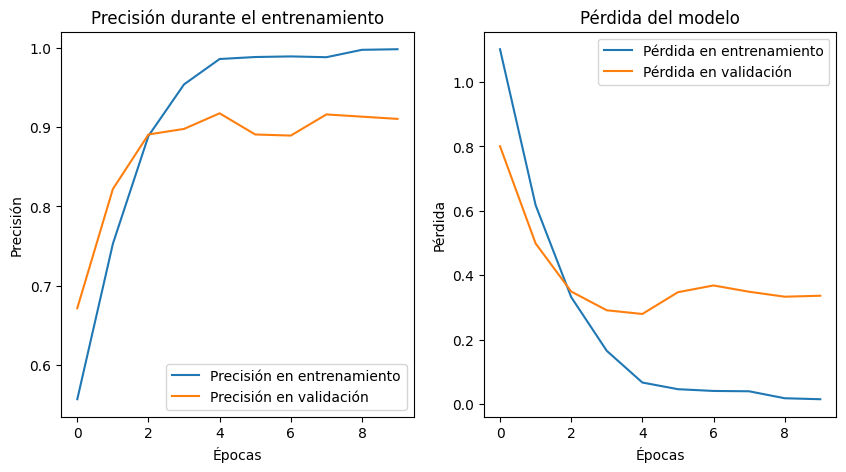

In [93]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(10, 5))  #

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history_X.history['accuracy'], label='Precisión en entrenamiento')  
plt.plot(history_X.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history_X.history['loss'], label='Pérdida en entrenamiento')  
plt.plot(history_X.history['val_loss'], label='Pérdida en validación')  
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

In [94]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

2024-10-25 03:53:59.074026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 38s 2s/step - loss: 3.9087 - accuracy: 0.3319 - precision: 0.3318 - recall: 0.3123 - auc: 0.6188 - f1_score: 0.6188
Pérdida en el conjunto de prueba: 3.90865421295166
accuracy en el conjunto de prueba: 0.33193278312683105
Precision en el conjunto de prueba: 0.331845223903656
Recall en el conjunto de prueba: 0.3123249411582947
AUC en el conjunto de prueba: 0.6187771558761597
F1-Score en el conjunto de prueba: 0.6187771558761597


**Matriz de confusión**

2024-10-25 03:54:37.461006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 39s 2s/step


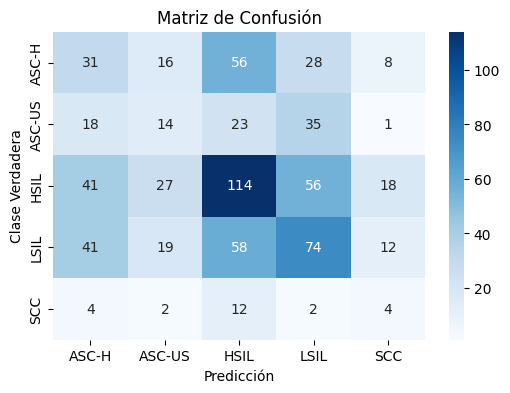

In [95]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()